In [1]:
# =====================================
# Programming for AI Final Project
# Team KDB
# Project Topic: Data-Driven Sustainability: Tracking Air, Water, and Energy for a Greener Future
# Subtopic: Energy
# Data Source: DATA.GOV.IE (https://data.gov.ie/dataset/dailygassupply)
# Dataset: Daily Gas Supply
# Date: Dec 12, 2024
# =====================================

In [2]:
from dotenv import load_dotenv
import os
import requests
from bs4 import BeautifulSoup
import mysql.connector
import json
from datetime import datetime
import csv

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# ============ Define the Website URL, JSON URL and file name ============
# define the Website URL, JSON URL and file name
json_url = "https://www.gasnetworks.ie/corporate/open-data/Q3-2024-Daily-Gas-Supply.json"
source_url = "https://data.gov.ie/dataset/dailygassupply"
file_name = "daily_gas_supply.json"

In [4]:
# ============ Function to check is the JSON file exists already in the folder ============
def check_if_json_exist():
    # check if the file already exists
    if os.path.exists(file_name):
        # check if the file is empty
        if os.path.getsize(file_name) > 0:
            print("JSON file already exists and is ready to use.")
        else:
            print("JSON file exists but is empty. Downloading again...")
            # call the function to fetch and save the JSON file
            fetch_and_save_json()
    else:
        print("JSON file does not exist. Downloading...")
        fetch_and_save_json()
        

In [5]:
# ============ Function to fetch and save the JSON file ============
def fetch_and_save_json():
    try:
        response = requests.get(json_url)
        if response.status_code == 200:
            with open(file_name, "w", encoding="utf-8") as file:
                file.write(response.text)
            # check the file size to see if empty
            if os.path.getsize(file_name) > 0:
                print("JSON file downloaded successfully.")
            else:
                print("Downloaded file is empty. Please check the URL or try again.")
        else: 
            print(f"Failed to download JSON file. HTTP Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {e}")
        

In [6]:
# ============ Function to fetch information about the dataset from the website via beautifulsoup ============
def scrape_metadata(source_url): 
    try:     
        response = requests.get(source_url)
        
        if response.status_code != 200:
             print(f"Failed to retrieve dataset information from the source website. Status code: {response.status_code}")
        
        soup = BeautifulSoup(response.content, "html.parser")
        
        # for debug purpose only 
        # print(soup.prettify())
        
        metadata_div = soup.find("div", class_="dataset-top-meta")
        if not metadata_div:
            print("Metadata container not found. Check if the HTML structure has changed.")
            return

        # extract metadata 
        published_by = metadata_div.find("a", href=lambda x: x and "/organization/" in x)
        published_by = published_by.text.strip() if published_by else "Not found"
        
        licensed_under = metadata_div.find("a", href=lambda x: x and "creativecommons.org" in x)
        licensed_under = licensed_under.text.strip() if licensed_under else "Not found"
        
        category = metadata_div.find("a", href=lambda x: x and "theme=Energy" in x)
        category = category.text.strip() if category else "Not found"

        description_div = soup.find("div", class_="notes embedded-content")
        description = description_div.find("p").text.strip() if description_div else "Not found"


        # Print the extracted information
        print(f"Published by: {published_by}")
        print(f"Licensed under: {licensed_under}")
        print(f"Category: {category}")
        print(f"Description: {description}")

    except Exception as e:
        print(f"An error occurred while scraping metadata: {e}")


In [7]:
# ============ Function to create the MySQL connection ============
def creat_db_connection():
    
    # load the environment variables to retrieve the MySQL elements
    load_dotenv("mysql.env")
    host = os.getenv('MYSQL_HOST')
    user = os.getenv('MYSQL_USER')
    password = os.getenv('MYSQL_PASSWORD')
    database = os.getenv('MYSQL_DATABASE')
    
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        if connection.is_connected():
            print("Connected to MySQL database successfully.")
            return connection
        else:
            print("Connection to MySQL failed unexpectedly.")
            return None
    except mysql.connector.Error as e:
        print(f"Error connecting to MySQL: {e}")
        return None


In [8]:
# ============ Function to insert JSON data into MySQL ============
def insert_json_to_mysql(connection):
    
    # check is connection is valid
    if not connection.is_connected():
        print("MySQL connection is not active. Please check again.")
        return
    
    try:
        # load the JSON file
        file_name = "daily_gas_supply.json"
        with open(file_name, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # check if JSON is empty
        if not data:
            print("JSON file is empty. No records to process.")
            return
        
        print(f"Processing {len(data)} records from the JSON file.")
            
        # prepare the SQL query
        # insert_query = "INSERT INTO daily_gas_supply (date, corrib_production, moffat, roi_imports, total) VALUES (%s, %s, %s, %s, %s)"
        
        insert_query = """
        INSERT INTO daily_gas_supply (date, corrib_production, moffat, roi_imports, total) 
        VALUES (%s, %s, %s, %s, %s)
        ON DUPLICATE KEY UPDATE 
            corrib_production = VALUES(corrib_production),
            moffat = VALUES(moffat),
            roi_imports = VALUES(roi_imports),
            total = VALUES(total) """
        
        # create a list of records to insert
        records_to_insert = []
        for record in data:
            
            # convert the data format
            raw_date = record.get("Date")  
            if raw_date:
                try:
                    formatted_date = datetime.strptime(raw_date, "%d/%m/%Y").strftime("%Y-%m-%d")
                except ValueError:
                    print(f"Skipping record with invalid date format: {raw_date}")
                    continue
            else:
                formatted_date = None
             
            corrib_production = record.get("Corrib production")  
            moffat = record.get("Moffat") 
            roi_imports = record.get("ROI imports via interconnector")  
            total = record.get("Total")
            
            # replace invalid or empty values with None
            corrib_production = corrib_production if corrib_production not in ("", None) else None
            moffat = moffat if moffat not in ("", None) else None
            roi_imports = roi_imports if roi_imports not in ("", None) else None
            total = total if total not in ("", None) else None
            
            # only insert data with a valid date
            if formatted_date:
                records_to_insert.append((formatted_date, corrib_production, moffat, roi_imports, total))
            
        if records_to_insert:
            cursor = connection.cursor()
            cursor.executemany(insert_query, records_to_insert)
            connection.commit()
            print(f"Successfully inserted {cursor.rowcount} rows into the 'daily_gas_supply' table.")
        else:
            print("No valid records found to insert into the database.")
            
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON file: {e}")
    except FileNotFoundError:
        print(f"JSON file '{file_name}' not found. Please check the file path.")
    except mysql.connector.Error as e:
        print(f"Error inserting data into MySQL: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally: 
        try:
            cursor.close()
        except Exception as e:
            print(f"An unexpected error occurred while closing the cursor: {e}")
            
        

In [9]:
# ============ Function to read the data from MySQL into a CSV file ============
def export_data_to_csv(connection, csv_file_path):
    
    # check is connection is valid
    if not connection.is_connected():
        print("MySQL connection is not active. Please check again.")
        return

    try: 
        query = "SELECT * FROM daily_gas_supply"
        cursor = connection.cursor()
        cursor.execute(query)
        rows = cursor.fetchall()
        
        if not rows:
            print("No data retrieved from the database.")
            return
        
        # define headers
        headers = ["id", "date", "corrib_production", "moffat","ROI_imports_via_interconnector", "total"] 
        
        try:
            # write data to CSV
            with open(csv_file_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(headers)  
                writer.writerows(rows)  
        except Exception as e:
            print(f"File write error: {e}")
            return
        
        # check if the file 
        if len(rows) > 0:
            print(f"Data successfully exported to {csv_file_path} with {len(rows)} rows.")
        else:
            print(f"Export failed: {csv_file_path} is empty.")
        
    except mysql.connector.Error as err:
        print(f"MySQL query execution failed: {err}")
    
    finally:
        if 'cursor' in locals() and cursor:
            cursor.close()


In [10]:
# ============ Function to store the processed output data in MySQL ============
def store_data_to_mysql(dataframe, table_name, connection):
    try:
        if not connection.is_connected():
            print("MySQL connection is not active. Please check again.")
            return
        
        cursor = connection.cursor()

        insert_query = f"""
        INSERT INTO {table_name} (date, corrib_production, moffat, roi_imports, total, year_and_month, year)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        ON DUPLICATE KEY UPDATE 
            corrib_production = VALUES(corrib_production),
            moffat = VALUES(moffat),
            roi_imports = VALUES(roi_imports),
            total = VALUES(total),
            year_and_month = VALUES(year_and_month),
            year = VALUES(year)
        """
        
        dataframe['year_month'] = dataframe['year_month'].dt.strftime('%Y-%m')
        
        # Prepare data to be inserted into the table
        records_to_insert = []
        for index, row in dataframe.iterrows():
            date = row['date']
            corrib_production = row['corrib_production']
            moffat = row['moffat']
            roi_imports = row['ROI_imports_via_interconnector']
            total = row['total']
            year_and_month = row['year_month']  
            year = row['year']
        
            records_to_insert.append((date, corrib_production, moffat, roi_imports, total, year_and_month, year))
        
        if records_to_insert:
            cursor.executemany(insert_query, records_to_insert)
            connection.commit()
            print(f"Successfully inserted {cursor.rowcount} rows into the 'clean_daily_gas_supply' table.")
        else:
            print("No valid records found to insert into the table.")
    except mysql.connector.Error as e:
        print(f"Error inserting data into MySQL: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if cursor:
            cursor.close()     
        
        
        

In [11]:
# ============ Answer to Project questions / requirements ============

# Requirement: JSON Dataset collection from an external source
print("\nStep 1: Checking for JSON file. If not exist, fetch the JSON from the source website...  ")
check_if_json_exist()
 
# Requirement: Scrape metadata from the source website 
print("\nStep 2: Scraping metadata from the source website via beautifulfsoup...")
scrape_metadata(source_url)

# Requirement: Create a database connection for storing and querying the data     
print("\nStep 3: Connecting to the database...")
connection = creat_db_connection()
    
if connection:
    try:
        # Requirement: Store the dataset into a MySQL database table
        print("\nStep 4: Inserting JSON data into MySQL...")
        insert_json_to_mysql(connection)
        
        # Requirement: Export the data from MySQL to a CSV file. 
        print("\nStep 5: Exporting data from MySQL to CSV...")
        export_data_to_csv(connection, "daily_gas_supply.csv")
        
    finally:
        connection.close()
        print("Database connection closed.")



Step 1: Checking for JSON file. If not exist, fetch the JSON from the source website...  
JSON file already exists and is ready to use.

Step 2: Scraping metadata from the source website via beautifulfsoup...
Published by: Gas Networks Ireland
Licensed under: Creative Commons Attribution 4.0
Category: Energy
Description: Daily gas supply for Ireland from January 1 2018 to the most recent quarter end. The data is updated quarterly.

Step 3: Connecting to the database...
Connected to MySQL database successfully.

Step 4: Inserting JSON data into MySQL...
Processing 2465 records from the JSON file.
Successfully inserted 0 rows into the 'daily_gas_supply' table.

Step 5: Exporting data from MySQL to CSV...
Data successfully exported to daily_gas_supply.csv with 2465 rows.
Database connection closed.


### Data pre-processing, transformation, analysis and visualisation

In [12]:
# load data
data_df = pd.read_csv("daily_gas_supply.csv")
print(data_df.head())

   id        date  corrib_production    moffat  \
0   1  2018-01-01            102.065   71.3111   
1   2  2018-01-02            101.202   72.3000   
2   3  2018-01-03            101.289   94.0222   
3   4  2018-01-04            102.012  128.0000   
4   5  2018-01-05            101.725  127.9000   

   ROI_imports_via_interconnector    total  
0                         27.1522  200.529  
1                         31.3790  204.881  
2                         51.2241  246.535  
3                         77.6498  307.662  
4                         84.7665  314.391  


In [13]:
# data population
print("Data population (number of rows): ", data_df.shape[0] )

Data population (number of rows):  2465


In [14]:
# column names
print("\nColumn Names: ", data_df.columns.tolist())


Column Names:  ['id', 'date', 'corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']


In [15]:
# type of attributes
print("\nTypes of data attributes: ", data_df.dtypes)


Types of data attributes:  id                                  int64
date                               object
corrib_production                 float64
moffat                            float64
ROI_imports_via_interconnector    float64
total                             float64
dtype: object


In [16]:
# convert 'date' column data type
data_df['date'] = pd.to_datetime(data_df['date'], format='%Y-%m-%d')
print("\nTypes of data attributes after converting 'date': ", data_df.dtypes)



Types of data attributes after converting 'date':  id                                         int64
date                              datetime64[ns]
corrib_production                        float64
moffat                                   float64
ROI_imports_via_interconnector           float64
total                                    float64
dtype: object


In [17]:
# check for missing values
print("\nMissing Values: ")
print(data_df.isnull().sum())


Missing Values: 
id                                  0
date                                0
corrib_production                   0
moffat                              0
ROI_imports_via_interconnector      0
total                             183
dtype: int64


In [18]:
# check for duplications:
print("\nDuplications: ")
print(data_df.duplicated().sum())


Duplications: 
0


In [19]:
# summary of relevant numerical columns:
numerical_columns = ['corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']
print("\nSummary of all numeric features:")
print(data_df[numerical_columns].describe())



Summary of all numeric features:
       corrib_production       moffat  ROI_imports_via_interconnector  \
count        2465.000000  2465.000000                     2465.000000   
mean           52.001919   148.392551                      100.110466   
std            21.797078    42.347912                       32.846315   
min             0.000000    35.444400                        7.691980   
25%            35.843300   119.189000                       77.649800   
50%            47.452000   146.433000                       98.042200   
75%            68.143200   173.636000                      120.503000   
max           102.123000   306.683000                      223.581000   

             total  
count  2282.000000  
mean    302.119298  
std      68.307394  
min     128.260000  
25%     257.475750  
50%     298.009000  
75%     340.661500  
max     568.132000  


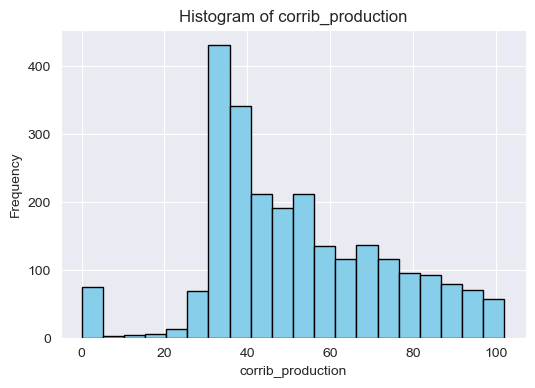

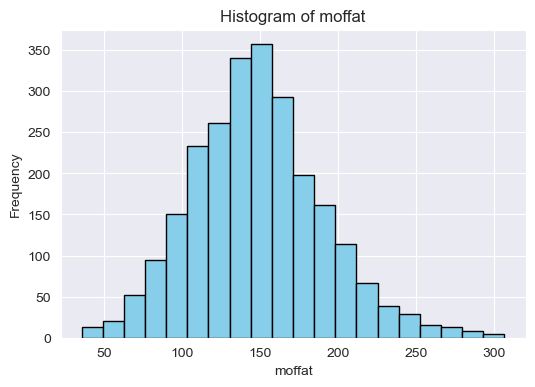

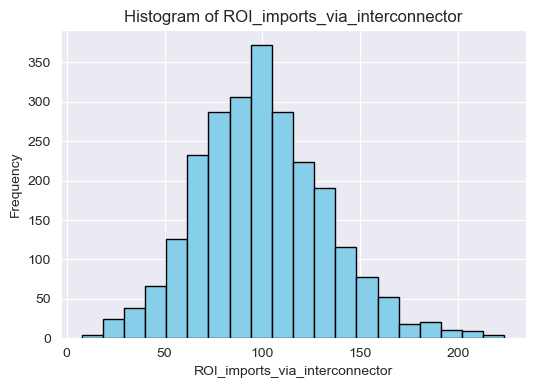

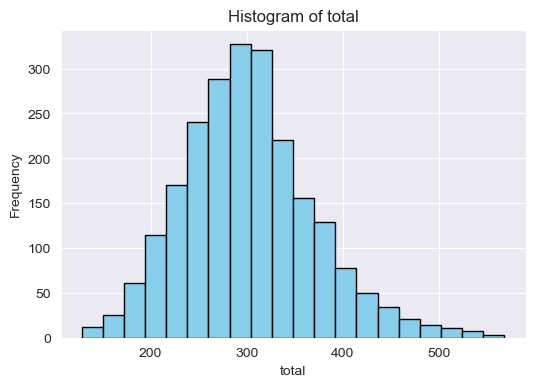

In [20]:
# visualization to check outliers & skewness
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(data_df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [21]:
# check skewness numerically
skewness = data_df[['corrib_production', 'moffat', 'ROI_imports_via_interconnector']].skew()
print("Skewness of Columns: \n")
print(skewness)

Skewness of Columns: 

corrib_production                 0.257754
moffat                            0.401662
ROI_imports_via_interconnector    0.361884
dtype: float64


In [22]:
# handle missing values

# fill missing values with the median for 'corrib_production' 
data_df['corrib_production'] = data_df['corrib_production'].fillna(data_df['corrib_production'].median())

# fill missing values with the mean for columns 'moffat', and 'ROI_imports_via_interconnector' 
data_df['moffat'] = data_df['moffat'].fillna(data_df['moffat'].mean())
data_df['ROI_imports_via_interconnector'] = data_df['ROI_imports_via_interconnector'].fillna(data_df['ROI_imports_via_interconnector'].mean())

# calculate 'total' where it is NaN (missing)
data_df['total'] = data_df['total'].fillna(
    data_df['corrib_production'] + data_df['moffat'] + data_df['ROI_imports_via_interconnector']
)

# check for missing values after handling missing values
print("\nMissing Values after handling missing values: ")
print(data_df.isnull().sum())


Missing Values after handling missing values: 
id                                0
date                              0
corrib_production                 0
moffat                            0
ROI_imports_via_interconnector    0
total                             0
dtype: int64


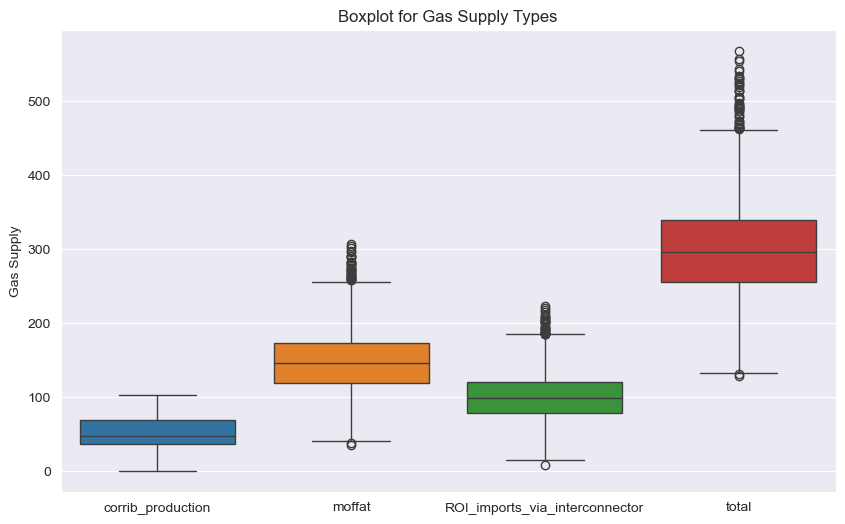

In [23]:
# Visualization: Boxplot for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df[['corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']])
plt.title('Boxplot for Gas Supply Types')
plt.ylabel('Gas Supply')
plt.show()

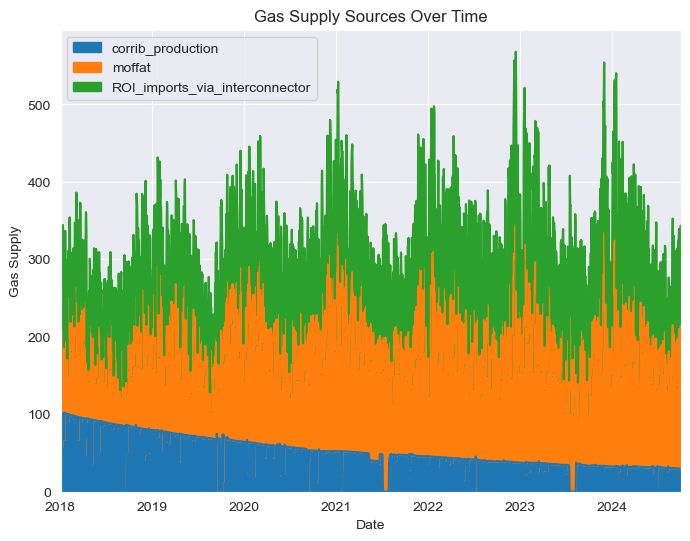

In [24]:
# Visualization: stacked area plot

# create a copy of the original dataset
data_df_copy = data_df.copy()

data_df_copy.set_index('date', inplace=True)

# Stacked area plot for supply sources
data_df_copy[['corrib_production', 'moffat', 'ROI_imports_via_interconnector']].plot(
    kind='area', figsize=(8, 6), stacked=True, title='Gas Supply Sources Over Time'
)
plt.xlabel('Date')
plt.ylabel('Gas Supply')
plt.show()


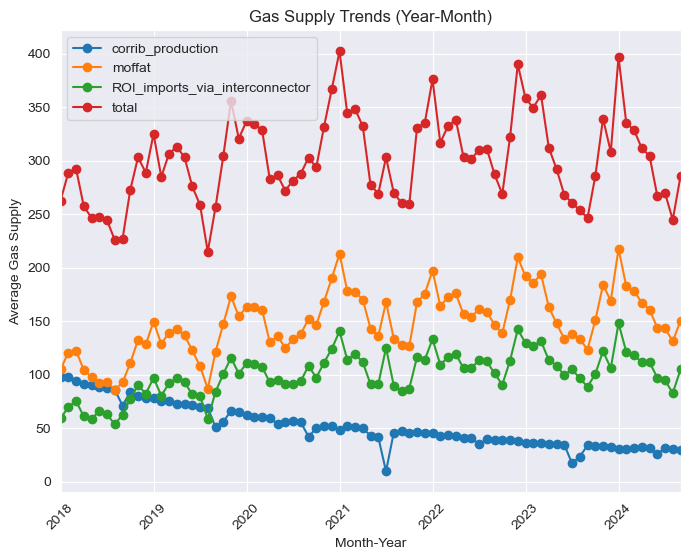

In [25]:
# visualization: line plot for monthly trend (average gas supply group by month and year)

# create a new column combining year and month
data_df['year_month'] = data_df['date'].dt.to_period('M')

# group by the 'year_month' column and calculate the mean for each group
monthly_trends = data_df.groupby('year_month')[['corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']].mean()

# Visualization: Line Plot for Monthly Trends
monthly_trends.plot(kind='line', figsize=(8, 6), marker='o', title='Gas Supply Trends (Year-Month)')
plt.xlabel('Month-Year')
plt.ylabel('Average Gas Supply')
plt.xticks(rotation=45)
plt.show()


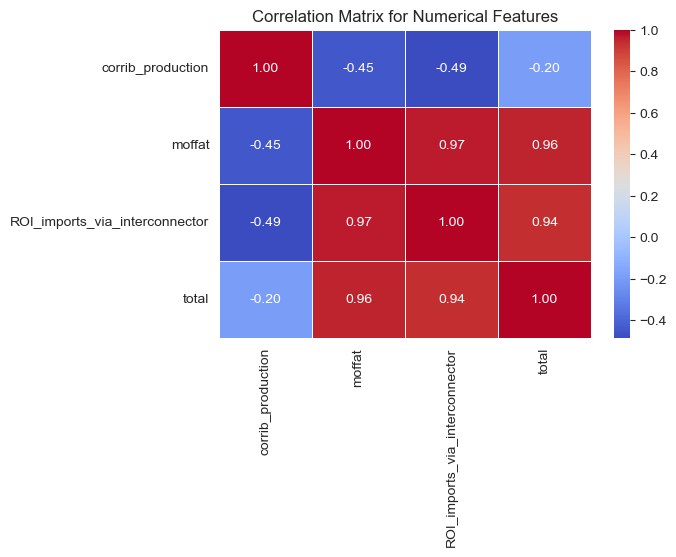

In [26]:
# visualization: correlation matrix 
correlation_matrix = data_df[['corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

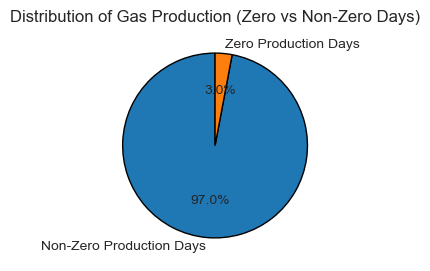

In [27]:
# visualization: the Zero Production Days for 'corrib_production'
total_days = data_df.shape[0]
zero_production_days = data_df[data_df['corrib_production'] == 0]
num_zero_production_days = zero_production_days.shape[0]
num_non_zero_production_days = total_days - num_zero_production_days


labels = ['Non-Zero Production Days', 'Zero Production Days']
sizes = [num_non_zero_production_days, num_zero_production_days]

plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Gas Production (Zero vs Non-Zero Days)')
plt.show()


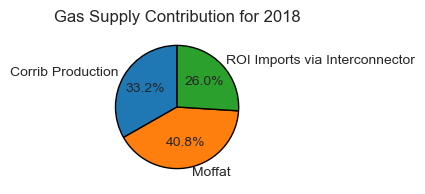

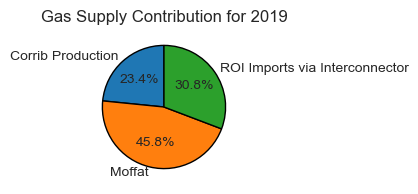

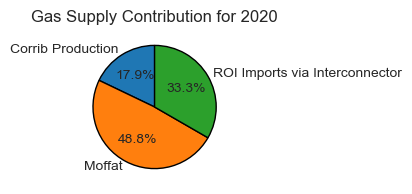

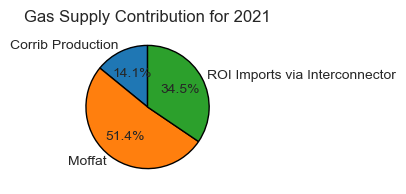

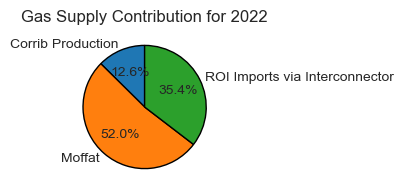

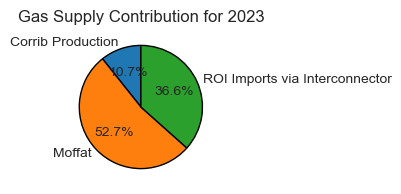

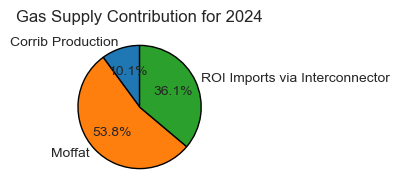

In [28]:
# visualization: contribution percentage of three types of gas supply sources

# create a 'year' column
data_df['year'] = pd.to_datetime(data_df['date']).dt.year

# group the date by 
annual_data = data_df.groupby('year')[['corrib_production', 'moffat', 'ROI_imports_via_interconnector', 'total']].sum()

# loop through each year to generate a pie chart
for year in annual_data.index:
    year_data = annual_data.loc[year]
    
    corrib_percentage = (year_data['corrib_production'] / year_data['total']) * 100
    moffat_percentage = (year_data['moffat'] / year_data['total']) * 100
    roi_imports_percentage = (year_data['ROI_imports_via_interconnector'] / year_data['total']) * 100
    
    labels = ['Corrib Production', 'Moffat', 'ROI Imports via Interconnector']
    sizes = [corrib_percentage, moffat_percentage, roi_imports_percentage]
    
    plt.figure(figsize=(2,2))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(f'Gas Supply Contribution for {year}')
    plt.show()
    


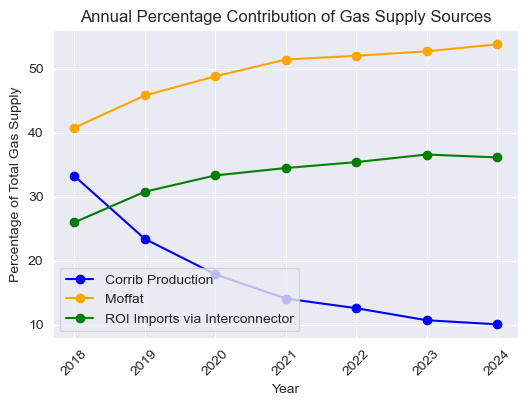

In [29]:
# visualization: annual percentage contribution of gas supply sources overtime

annual_data['corrib_percentage'] = (annual_data['corrib_production'] / annual_data['total']) * 100
annual_data['moffat_percentage'] = (annual_data['moffat'] / annual_data['total']) * 100
annual_data['roi_imports_percentage'] = (annual_data['ROI_imports_via_interconnector'] / annual_data['total']) * 100

plt.figure(figsize=(6, 4))
plt.plot(annual_data.index, annual_data['corrib_percentage'], label='Corrib Production', marker='o', color='blue')
plt.plot(annual_data.index, annual_data['moffat_percentage'], label='Moffat', marker='o', color='orange')
plt.plot(annual_data.index, annual_data['roi_imports_percentage'], label='ROI Imports via Interconnector', marker='o', color='green')

plt.title('Annual Percentage Contribution of Gas Supply Sources')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Gas Supply')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

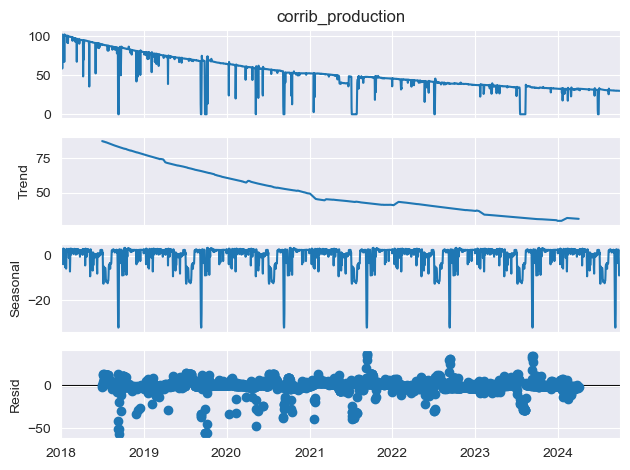

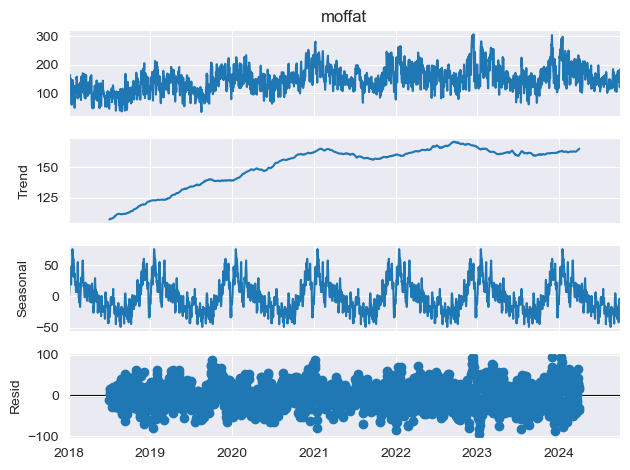

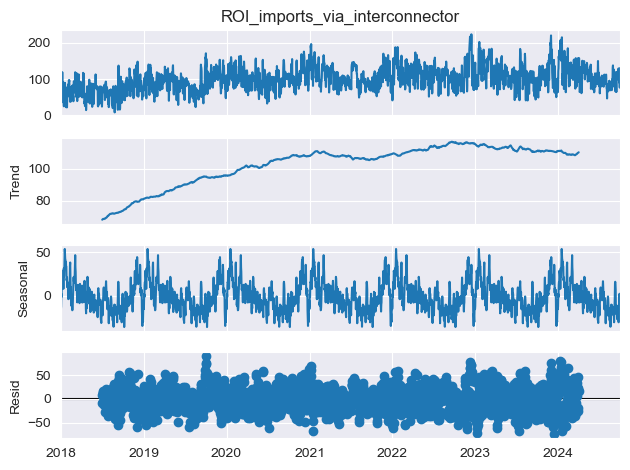

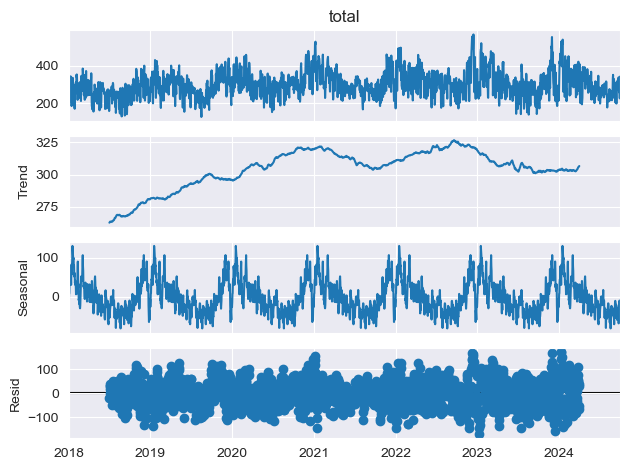

In [30]:
# Seasonal decomposition 

# cody the dataframe to reset the 'date' column as the index
data_df_copy = data_df.copy()
data_df_copy.set_index('date', inplace=True)

# Seasonal decomposition for 'corrib_production'
seasonal_decomp_corrib = seasonal_decompose(data_df_copy['corrib_production'], model='additive', period=365)
seasonal_decomp_corrib.plot()
plt.show()

# seasonal decomposition for 'moffat'
seasonal_decomp_moffat = seasonal_decompose(data_df_copy['moffat'], model='additive', period=365)
seasonal_decomp_moffat.plot()
plt.show()

# seasonal decomposition for 'ROI_imports_via_interconnector'
seasonal_decomp_roi = seasonal_decompose(data_df_copy['ROI_imports_via_interconnector'], model='additive', period=365)
seasonal_decomp_roi.plot()
plt.show()

# seasonal decomposition for 'total'
seasonal_decomp_roi = seasonal_decompose(data_df_copy['total'], model='additive', period=365)
seasonal_decomp_roi.plot()
plt.show()

In [31]:
# ============ Answer to Project questions / requirements ============

# Requirement: store the data into a MySQL database table

# Create a database connection 
print("\nConnecting to the database...")
connection = creat_db_connection()
    
if connection:
    try:
        print("\nStep 7: Storing processed clean data into MySQL...")
        store_data_to_mysql(data_df, 'clean_daily_gas_supply', connection)
    except Exception as e:
        print(f"An error occurred while storing data into MySQL: {e}")
    finally:
        connection.close()
        print("Database connection closed.")


Connecting to the database...
Connected to MySQL database successfully.

Step 7: Storing processed clean data into MySQL...
Successfully inserted 0 rows into the 'clean_daily_gas_supply' table.
Database connection closed.


### Predictive Modeling with Machine Learning 

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [33]:
# ========== Linear Regression ==========

# select 'total' as target
features = ['corrib_production', 'moffat', 'ROI_imports_via_interconnector']
target = 'total'

X = data_df[features]
y = data_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# to evaluate how well the model predicts the data
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')

# to evaluate how well the model fits the data.
print(f'R2 Score: {r2_score(y_test, y_pred)}')

# to evaluate how much each feature impacts the target
print(f'Feature Coefficients: {model.coef_}')

Mean Squared Error: 1.8710518930030738e-07
R2 Score: 0.9999999999591521
Feature Coefficients: [1.00000032 1.00000077 0.99999914]


In [34]:
# ========== Random Forest ==========

# initialize the Random Forest Regressor model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'Feature Importances: {rf_model.feature_importances_}')

Mean Squared Error: 12.391892363115597
R2 Score: 0.9972946639294424
Feature Importances: [0.05011476 0.8211936  0.12869164]


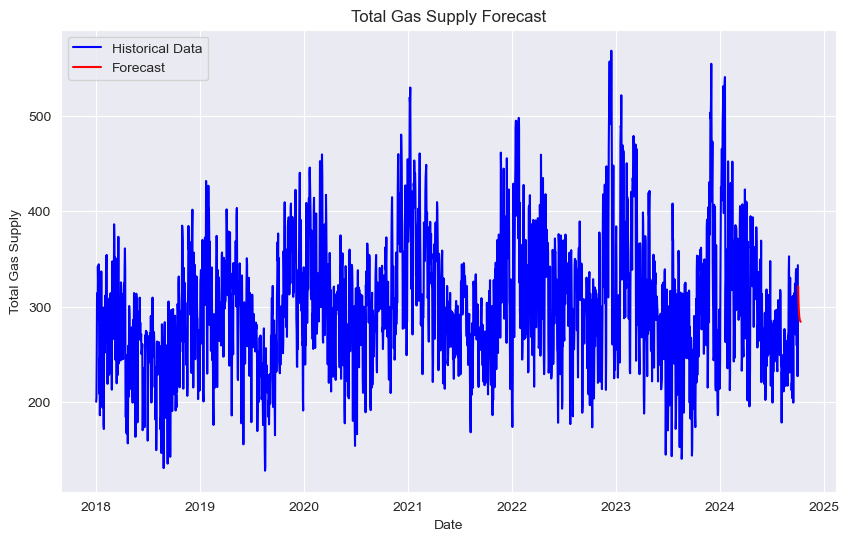

In [35]:
# ========== Time-Series Forecasting - ARIMA Model ==========

# create a copy of the original dataframe
df_copy_2 = data_df.copy()

# convert the 'date' column to datetime
df_copy_2['date'] = pd.to_datetime(df_copy_2['date'])

# set the 'date' column as the index
df_copy_2.set_index('date', inplace=True)

# set the frequency daily
df_copy_2 = df_copy_2.asfreq('D') 

# fit the ARIMA model
arima_model = ARIMA(df_copy_2['total'], order=(1, 1, 1))
arima_fitted = arima_model.fit()

# forecast the next 10 days
forecast_steps = 10
forecast = arima_fitted.forecast(steps=forecast_steps)

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_copy_2.index, df_copy_2['total'], label='Historical Data', color='blue')

# create a forecast index for the next 10 days
forecast_index = pd.date_range(start=df_copy_2.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')

plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Total Gas Supply')
plt.title('Total Gas Supply Forecast')
plt.legend()
plt.show()